In [1]:
import numpy as np
import pandas as pd
import pymorphy2 as pm2
import re
import nltk
nltk.download("stopwords")
#--------#
from nltk.corpus import stopwords

#Create lemmatizer and stopwords list
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/valeria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv('jaguar.csv')
data = data.sample(frac=1)
pmm = pm2.MorphAnalyzer()

In [4]:
def parse(text):
    text = re.sub(r'[^\w\s]','',text)
    text = [pmm.normal_forms(x)[0] for x in text.split() if x not in russian_stopwords]
    return text

In [5]:
jaguar_corpus = data['body'].apply(parse)

In [165]:
jaguar_corpus

0     [ягуар, panthera, onca, вид, хищный, млекопита...
1     [на, вид, американский, зверь, вылить, леопард...
2     [ягуар, хищник, семейство, кошачий, принадлежа...
3     [название, название, ягуар, предположительно, ...
4     [ягуар, относиться, один, самый, крупный, живо...
5     [один, крупный, хищный, млекопитающее, семейст...
6     [в, влажный, тропический, леса, центральный, ю...
7     [ягуар, крупный, хищник, южный, америка, этот,...
8     [ягуар, млекопитающее, семейство, кошачий, сво...
9     [большой, грациозный, кошка, ягуар, обитать, и...
10    [jaguar, напиток, jaguar, слабоалкогольный, га...
11    [слабоалкогольный, напиток, ягуар, самый, попу...
12    [jaguar, популярный, мир, энергетический, напи...
13    [яга, это, легенда, как, свой, время, легенда,...
14    [напиток, ягуар, алкогольный, энергетик, напит...
15    [слабоалкогольный, энергетический, напиток, яг...
16    [напиток, ягуар, jaguar, начать, появляться, р...
17    [энергетический, алкогольный, напиток, пра

# Word embeddings

In [100]:
from gensim.models import Word2Vec

model = Word2Vec(jaguar_corpus, size=300, window=5, min_count=5, iter=10)
model.init_sims(replace = True)
model.save("jaguar.model")

# Word embeddings' clusterization

In [151]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import  ward, dendrogram

dist = 1 - cosine_similarity(model[model.wv.vocab])
linkage_matrix = ward(dist)
dist

/home/valeria/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


array([[-3.5762787e-07,  2.2172928e-04,  3.8266182e-05, ...,
         4.8708916e-04,  1.8447638e-04,  2.3812056e-04],
       [ 2.2172928e-04, -2.3841858e-07,  2.4026632e-04, ...,
         7.1251392e-04,  4.0531158e-04,  4.3463707e-04],
       [ 3.8266182e-05,  2.4026632e-04,  0.0000000e+00, ...,
         4.7928095e-04,  2.0301342e-04,  2.4634600e-04],
       ...,
       [ 4.8708916e-04,  7.1251392e-04,  4.7928095e-04, ...,
         1.1920929e-07,  6.5922737e-04,  7.3200464e-04],
       [ 1.8447638e-04,  4.0531158e-04,  2.0301342e-04, ...,
         6.5922737e-04,  0.0000000e+00,  4.3761730e-04],
       [ 2.3812056e-04,  4.3463707e-04,  2.4634600e-04, ...,
         7.3200464e-04,  4.3761730e-04, -2.3841858e-07]], dtype=float32)

In [158]:
labels = [el for el in model.wv.vocab]

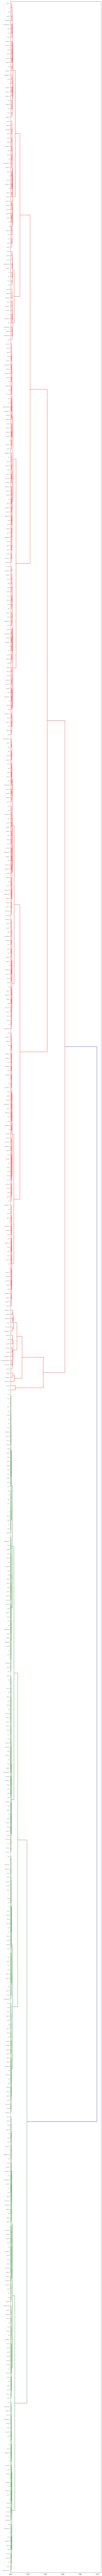

In [159]:
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 250)) 
ax = dendrogram(linkage_matrix, orientation="right", labels=labels);

pyplot.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

pyplot.tight_layout() 

pyplot.savefig('w2v_clusters.png', dpi=200) #save figure as ward_clusters

# Docs embeddings

In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import string

jaguar_corpus = data['body'].values.tolist()

def preprocessing(line):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    return line

In [189]:
tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocessing)
tfidf = tfidf_vectorizer.fit_transform(jaguar_corpus)

km = KMeans(n_clusters=5)

In [190]:
idx = km.fit(tfidf)
clusters = km.labels_.tolist()

print(clusters)
print (km.labels_)

[0, 0, 0, 0, 0, 0, 4, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 4, 4, 0, 4, 4, 4, 4, 0, 4, 1, 2, 3, 1, 2, 2, 3, 2, 2, 2, 3]
[0 0 0 0 0 0 4 0 4 2 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 4 4 0 4 4 4 4
 0 4 1 2 3 1 2 2 3 2 2 2 3]


In [196]:
cent = km.cluster_centers_
cent

array([[0.00225403, 0.00203841, 0.00112701, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01886614, 0.        ,
        0.        ],
       [0.        , 0.01190987, 0.        , ..., 0.        , 0.00264561,
        0.00264561],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])